In [16]:
import os
import json
import csv
import random
import pandas as pd
from openai import OpenAI
from dotenv import load_dotenv

In [27]:
# Initialize the OpenAI client
# The client automatically reads the OPENAI_API_KEY environment variable.
# If you prefer to set it directly (not recommended for shared code), use:
#     client = OpenAI(api_key='sk-your-key-here')

load_dotenv()

client = OpenAI(
    api_key = os.getenv("GEMINI_API_KEY"),
    base_url = "https://generativelanguage.googleapis.com/v1beta/openai/"
)

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/data/master/comma-survey/comma-survey.csv")
survey_data = df.to_dict('records')

def generate_gpt_prompts(data):

    prompts = []
    
    for row in data:
        
        # Add get() to return 'Not specified' instead of NaN
        age = row.get('Age', 'Not specified')
        gender = row.get('Gender', 'Not specified')
        education = row.get('Education', 'Not specified')
        income = row.get('Household Income', 'Not specified')
        region = row.get('Location (Census Region)', 'Not specified')

        prompt = f"""
        You are a survey respondent with the following demographics:
        - Age: {age}
        - Gender: {gender}
        - Education: {education}
        - Income: {income}
        - Region: {region}
        
        Answer the following questions as if you are this person.
        CRITICAL INSTRUCTIONS: 
            1. Output your answer ONLY as a valid JSON object.
            2. For the value, use the **EXACT TEXT** of the option you choose. DO NOT use the letter (e.g., do not output "(A)", output "Yes").

            REQUIRED JSON STRUCTURE (Example):
            {{
            "llm_preference": "It's important for a person to be honest, kind, and loyal.",
            "llm_prior": "Yes",
            "llm_comma_care": "Some",
            "llm_sentence_example": "Some experts say it's important to drink milk, but the data is inconclusive.",
            "llm_data": "No",
            "llm_data_care": "Not much",
            "llm_grammar_importance": "Very important"
            }}

            SURVEY QUESTIONS:

            1. In your opinion, which sentence is more gramatically correct?
            (A) It's important for a person to be honest, kind, and loyal.
            (B) It's important for a person to be honest, kind and loyal.

            2. Prior to reading about it above, had you heard of the serial (or Oxford) comma?
            (A) Yes
            (B) No

            3. How much, if at all, do you care about the use (or lack thereof) of the serial (or Oxford) comma in grammar?
            (A) A lot
            (B) Some
            (C) Not much
            (D) Not at all

            4. How would you write the following sentence?
            (A) Some experts say it's important to drink milk, but the data is inconclusive.
            (B) Some experts say it's important to drink milk, but the data are inconclusive.

            5. When faced with using the word "data", have you ever spent time considering if the word was a singular or plural noun?
            (A) Yes
            (B) No

            6. How much, if at all, do you care about the debate over the use of the word "data" as a singluar or plural noun?
            (A) A lot
            (B) Some
            (C) Not much
            (D) Not at all

            7. In your opinion, how important or unimportant is proper use of grammar?
            (A) Very important
            (B) Somewhat important
            (C) Neither important nor unimportant (neutral)
            (D) Somewhat unimportant
            (E) Very unimportant
        """
        prompts.append(prompt)

    return prompts


def poll_gpt(gpt_prompts, original_data):
    
    responses = []
    
    for i, prompt in enumerate(gpt_prompts):
        response = client.chat.completions.create(
            model="gemini-2.0-flash",
            messages=[
                {"role": "system", "content": "You are a survey participant. Output strictly in JSON."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=1000,
            n=1,
            temperature=1.0,
            response_format={"type": "json_object"} # Mandate JSON structure
        )

        # Expanded to parse JSON string into dict and merge with original demographic data
        content = response.choices[0].message.content.strip()
        answer_dict = json.loads(content)
        merged_record = {**original_data[i], **answer_dict}
        responses.append(merged_record)

    return responses


# Randomly select 300 rows (you can use a more sophisticated method for randomness). Set seed if needed.
num_responses = 1
selected_data = random.sample(survey_data, num_responses)

# Generate GPT prompts based on the demographics
gpt_prompts = generate_gpt_prompts(selected_data)

# Poll GPT for survey responses (e.g. poll 300 GPT responses)
gpt_responses = poll_gpt(gpt_prompts, selected_data)
headers = list(gpt_responses[0].keys())

with open('gpt_survey.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=headers)
    writer.writeheader()
    writer.writerows(gpt_responses)


========== Q1: Oxford Comma Preference ==========
                                              Answer Percentage_Human Percentage_LLM    Diff
0  It's important for a person to be honest, kind...            43.2%           0.0%  -43.2%
1  It's important for a person to be honest, kind...            56.8%         100.0%  +43.2%

========== Q2: Heard of Oxford Comma? ==========
  Answer Percentage_Human Percentage_LLM   Diff
0     No            40.4%          47.7%  +7.3%
1    Yes            59.6%          52.3%  -7.3%

========== Q3: Care about Oxford Comma? ==========
       Answer Percentage_Human Percentage_LLM    Diff
0       A lot            26.5%           1.7%  -24.8%
1  Not at all            11.5%           0.3%  -11.1%
2    Not much            24.4%          17.0%   -7.4%
3        Some            37.7%          81.0%  +43.3%

========== Q4: Sentence Example Preference ==========
                                              Answer Percentage_Human Percentage_LLM    Diff
0  Som

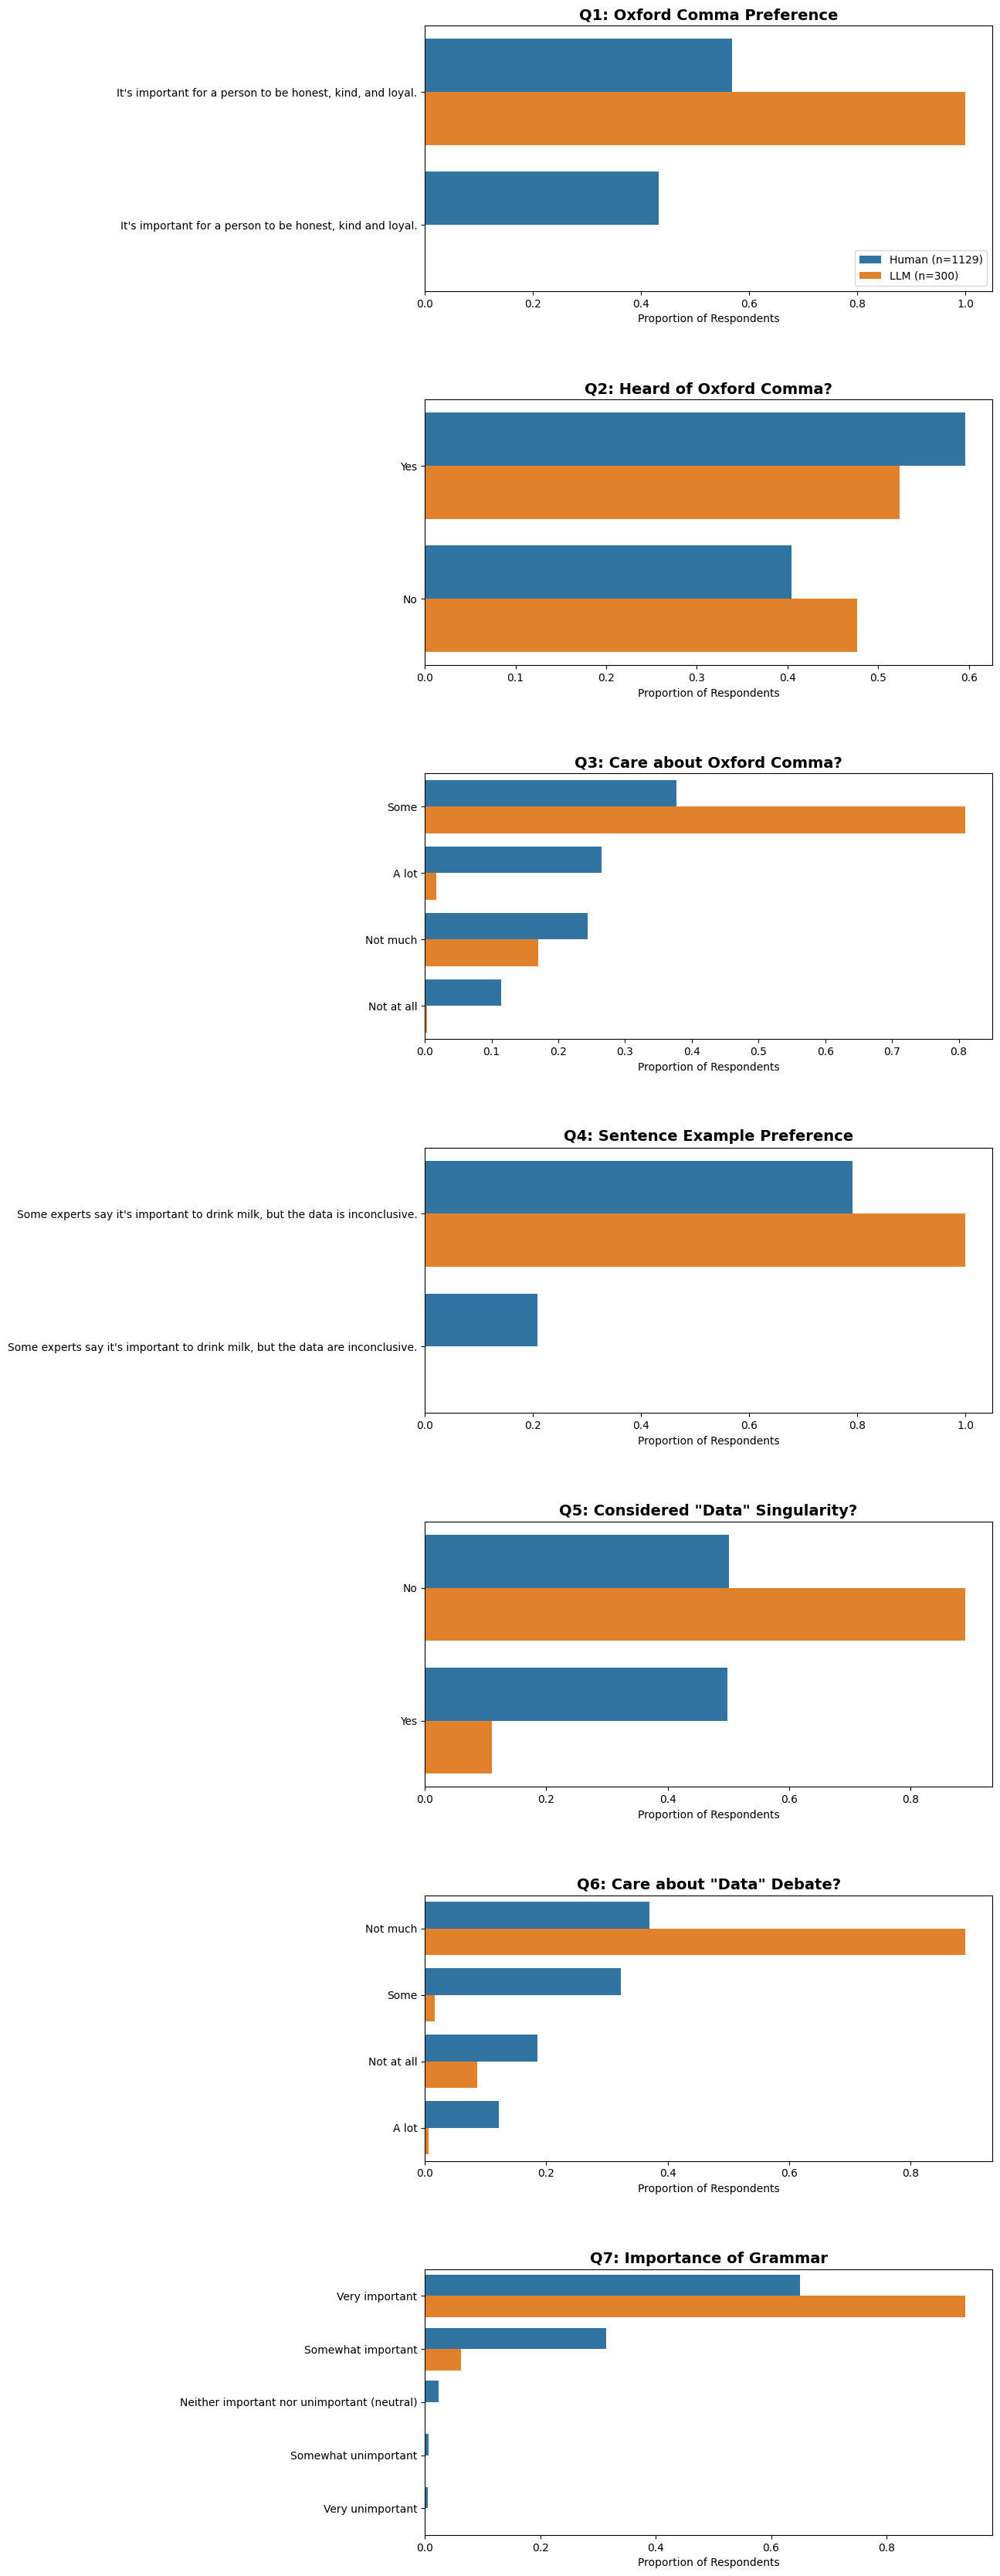

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_human_full = pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/data/master/comma-survey/comma-survey.csv")
df_llm = pd.read_csv('gpt_survey.csv')

comparison_map = [
    (
        'In your opinion, which sentence is more gramatically correct?',
        'llm_preference',
        'Q1: Oxford Comma Preference'
    ),
    (
        'Prior to reading about it above, had you heard of the serial (or Oxford) comma?',
        'llm_prior',
        'Q2: Heard of Oxford Comma?'
    ),
    (
        'How much, if at all, do you care about the use (or lack thereof) of the serial (or Oxford) comma in grammar?',
        'llm_comma_care',
        'Q3: Care about Oxford Comma?'
    ),
    (
        'How would you write the following sentence?',
        'llm_sentence_example',
        'Q4: Sentence Example Preference'
    ),
    (
        'When faced with using the word "data", have you ever spent time considering if the word was a singular or plural noun?',
        'llm_data',
        'Q5: Considered "Data" Singularity?'
    ),
    (
        'How much, if at all, do you care about the debate over the use of the word "data" as a singluar or plural noun?',
        'llm_data_care',
        'Q6: Care about "Data" Debate?'
    ),
    (
        'In your opinion, how important or unimportant is proper use of grammar?',
        'llm_grammar_importance',
        'Q7: Importance of Grammar'
    )
]

# 3. Setup the visualization figure
fig, axes = plt.subplots(nrows=len(comparison_map), ncols=1, figsize=(10, 35))
fig.tight_layout(pad=8.0)

# 4. Loop through each question
for i, (human_col, llm_col, title) in enumerate(comparison_map):
    
    # --- A. Compute Frequencies ---
    
    # Human (Full Population)
    human_counts = df_human_full[human_col].value_counts(normalize=True).reset_index()
    human_counts.columns = ['Answer', 'Percentage']
    human_counts['Source'] = f'Human (n={len(df_human_full)})'
    
    # LLM (Sample)
    llm_counts = df_llm[llm_col].value_counts(normalize=True).reset_index()
    llm_counts.columns = ['Answer', 'Percentage']
    llm_counts['Source'] = f'LLM (n={len(df_llm)})'
    
    # Combine for Plotting
    plot_data = pd.concat([human_counts, llm_counts])
    
    # --- B. Present Data Side-by-Side (Required for Report) ---
    print(f"\n{'='*10} {title} {'='*10}")
    comparison_table = pd.merge(
        human_counts[['Answer', 'Percentage']], 
        llm_counts[['Answer', 'Percentage']], 
        on='Answer', 
        how='outer', 
        suffixes=('_Human', '_LLM')
    ).fillna(0)
    
    # Calculate Difference
    comparison_table['Diff'] = comparison_table['Percentage_LLM'] - comparison_table['Percentage_Human']
    
    # Format for readability
    comparison_table['Percentage_Human'] = comparison_table['Percentage_Human'].apply(lambda x: f"{x:.1%}")
    comparison_table['Percentage_LLM'] = comparison_table['Percentage_LLM'].apply(lambda x: f"{x:.1%}")
    comparison_table['Diff'] = comparison_table['Diff'].apply(lambda x: f"{x:+.1%}")
    
    print(comparison_table)
    
    # --- C. Create Visualization ---
    sns.barplot(
        data=plot_data, 
        x='Percentage', 
        y='Answer', 
        hue='Source', 
        ax=axes[i], 
        palette=['#1f77b4', '#ff7f0e']
    )
    
    axes[i].set_title(title, fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Proportion of Respondents')
    axes[i].set_ylabel('')
    
    if i == 0:
        axes[i].legend(loc='lower right')
    else:
        if axes[i].get_legend():
            axes[i].get_legend().remove()

# 5. Save the Plot
plt.savefig('step3_population_vs_llm.png', bbox_inches='tight')
plt.show()